In [1]:
### Install AIF360
# !pip install 'aif360'

In [18]:
import pandas as pd 
import numpy as np
from tqdm.auto import tqdm
from aif360.sklearn.metrics import disparate_impact_ratio, difference

from sklearn.metrics import roc_auc_score
from sklearn.metrics import f1_score
from sklearn.metrics import accuracy_score

In [19]:
# ToDo: Change the logic for the following data collection
test_df = pd.read_csv("../data/fairness_test.csv")

In [20]:
# smaller, as ORES empty scores are filtered
len(test_df)

954470

In [21]:
test_df.head(3)

,wiki_db,revision_id,revision_is_identity_reverted,is_anonymous,ores_pred,classifier_ml_anon_non_balanced_new_pred,classifier_ml_anon_non_balanced_mlm_new_pred,classifier_ml_all_non_balanced_new_pred,classifier_ml_all_non_balanced_user_features_new_pred,classifier_ml_all_non_balanced_mlm_new_pred,classifier_ml_all_non_balanced_user_features_mlm_new_pred
0,lvwiki,3642897,0,False,0.064643,0.793565,0.595658,0.767729,0.606200,0.258013,0.183207
1,lvwiki,3644717,0,False,0.065648,0.589894,0.305145,0.119167,0.031749,0.069964,0.021806
2,lvwiki,3646513,0,False,0.028898,0.475092,0.234674,0.092051,0.012829,0.027952,0.006952


In [22]:
test_df.index = pd.MultiIndex.from_arrays([test_df.is_anonymous.values], names=["is_anon"])

## Examples: 

In [23]:
y_pred = test_df.ores_pred > 0.5
y_test = test_df.revision_is_identity_reverted
accuracy_score(y_test, y_pred)

0.8768038806877115

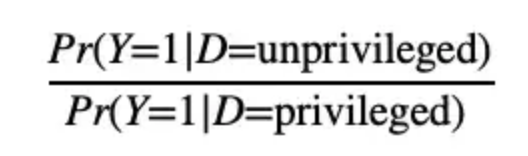

In [8]:
disparate_impact_ratio(y_test, y_pred, prot_attr='is_anon')

0.04993814464573333

# Calculating results for each algorithm: 

In [24]:
def calculate_metrics(y_pred, y_test, threshold=0.5, prot_attr="is_anon", priv_group=0):
    y_pred_b = y_pred > threshold
    results_dict = {
#         "accuracy_score": accuracy_score(y_test, y_pred_b),
        "disparate_impact_ratio_base": disparate_impact_ratio(
            y_test, prot_attr=prot_attr, priv_group=priv_group
        ),
        "disparate_impact_ratio": disparate_impact_ratio(
            y_test, y_pred_b, prot_attr=prot_attr, priv_group=priv_group
        ),
#         "statistical_parity_difference": statistical_parity_difference(
#             y_test, y_pred_b, prot_attr=prot_attr, priv_group=priv_group
#         ),
#         "kl_divergence": kl_divergence(y_test, y_pred_b, prot_attr=prot_attr, priv_group=priv_group),
        "AUC difference": difference(roc_auc_score, y_test, y_pred, prot_attr=prot_attr, priv_group=priv_group),
#         "F1 difference": difference(f1_score, y_test, y_pred_b, prot_attr=prot_attr, priv_group=priv_group),
#         "Accuracy difference": difference(accuracy_score, y_test, y_pred_b, prot_attr=prot_attr, priv_group=priv_group)
    }
    return results_dict

calculate_metrics(y_pred, y_test, threshold=0.5, prot_attr="is_anon")

{'disparate_impact_ratio_base': 7.934051007260494,
 'disparate_impact_ratio': 20.024772788298595,
 'AUC difference': 0.02107608534192651}

In [26]:
results = []

model_names = [
    "ores",
    "classifier_ml_anon_non_balanced_new",
    "classifier_ml_anon_non_balanced_mlm_new",
    "classifier_ml_all_non_balanced_new",
    "classifier_ml_all_non_balanced_mlm_new",
    "classifier_ml_all_non_balanced_user_features_new",
    "classifier_ml_all_non_balanced_user_features_mlm_new",
]

for name in model_names:
    results.append(calculate_metrics(
        test_df[f"{name}_pred"], test_df.revision_is_identity_reverted, threshold=0.5, prot_attr="is_anon")
                  )

In [27]:
res = pd.DataFrame(results)
res.index = model_names
res

,disparate_impact_ratio_base,disparate_impact_ratio,AUC difference
ores,7.934051,20.024773,-0.043372
classifier_ml_anon_non_balanced_new,7.934051,1.977697,0.072528
classifier_ml_anon_non_balanced_mlm_new,7.934051,2.055881,0.083683
classifier_ml_all_non_balanced_new,7.934051,2.907305,0.010664
classifier_ml_all_non_balanced_mlm_new,7.934051,3.083725,0.017365
classifier_ml_all_non_balanced_user_features_new,7.934051,9.360455,-0.035409
classifier_ml_all_non_balanced_user_features_mlm_new,7.934051,9.541478,-0.017267
